# Libraries


In [ ]:
# Import necessary libraries for building and evaluating a neural network
import os
import numpy as np
import joblib
import matplotlib.pyplot as plt
import librosa


# Layers from Keras (for defining the model architecture)
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, Activation

# Sequential model class from Keras (to build the model layer by layer)
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam

# Evaluation tools from Scikit-learn (to assess model performance)
from sklearn.metrics import confusion_matrix, classification_report

# Data splitting tool from Scikit-learn (to split the data into training and testing sets)
from sklearn.model_selection import train_test_split



___
Testing Audio Files

from IPython.display import Audio, display
a_path = '/home/badri/B/ser/datasets/revdess/Actor_01/03-01-01-01-01-01-01.wav'
a_path = '/home/badri/B/ser/datasets/neutral.wav'
sr = 22050
display(Audio(filename=a_path, rate = sr))
a_path = '/home/badri/B/ser/datasets/sad_audio.wav'

y,sam_r = librosa.load(a_path, sr = sr)

plt.figure(figsize=(14,5))
librosa.display.waveshow(y, sr = sr)
plt.title("testing_wave_form")
plt.show()

end
___


# Feature Extraction


%%time


def extract_mfcc(file_path, sr = 22050, n_mfcc = 40):
    y,sr = librosa.load(file_path, sr=sr, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

dataset_path = '/home/badri/B/ser/datasets/revdess/'

mfcc_features = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith('.wav'):
            try:
                file_path = os.path.join(root, file)
                mfccs = extract_mfcc(file_path)
                file_class = int(file[7:8]) -1 
                mfcc_features.append((mfccs, file_class))
            except ValueError as err:
                print(f"Error processing file {file}: {err}")
                continue
                
print(f" Extracted {len(mfcc_features)}files")
for  i in range(10):
    print(mfcc_features[i])
    
    


# saving Features 

%%time


x, y = zip(*mfcc_features)
x, y = np.asarray(x), np.asarray(y)
print(x.shape, y.shape)

save_dir_path = '/home/badri/B/ser/datasets/MFCC_Features'

joblib.dump(x, os.path.join(save_dir_path, 'x.joblib'))
joblib.dump(y, os.path.join(save_dir_path, 'y.joblib'))

In [ ]:
x = joblib.load('/home/badri/B/ser/datasets/MFCC_Features/x.joblib')
y = joblib.load('/home/badri/B/ser/datasets/MFCC_Features/y.joblib')



In [ ]:
%%time
x_train,  x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

x_traincnn = np.expand_dims(x_train, axis = 2)
x_testcnn = np.expand_dims(x_test, axis = 2)
print(x_traincnn.shape, x_testcnn.shape)

# Model Architecture

In [ ]:
model = Sequential()
model.add(Conv1D(64, 5, padding='same', input_shape=(40, 1)))  # Conv1D layer
model.add(Activation('relu'))  # Activation layer
model.add(Dropout(0.2))  # Dropout layer
model.add(Flatten())  # Flatten layer
model.add(Dense(8))  # Dense layer
model.add(Activation('softmax'))  # Activation layer
model.summary()


# Model Training

%%time
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_traincnn, y_train, epochs=70, batch_size=32, validation_data=(x_testcnn, y_test))

y_pred = model.predict(x_testcnn)
y_pred_classes = np.argmax(y_pred, axis =1)
print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel("accuracy")
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel("loss")

plt.legend(loc='upper right')
plt.show()

# save model 

model.save('/home/badri/B/ser/saved_models/model291220241521.keras')

# Load saved model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/home/badri/B/ser/saved_models/model291220241521.keras')
model.summary()

# Methods def

In [ ]:

def extract_mfcc(file_path, sr = 22050, n_mfcc = 40):
    y,sr = librosa.load(file_path, sr=sr, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

def audio_input(audio_path):
    mfccs = extract_mfcc(audio_path)
    new_mfccs = np.expand_dims(mfccs, axis = 0)
    new_mfccs = np.expand_dims(new_mfccs, axis = -1)
    return new_mfccs
    
    

In [ ]:
y_pred = model.predict(audio_input('/home/badri/B/ser/datasets/Nappy.wav'))
y_pred_class = np.argmax(y_pred, axis = 1)

# Feedback Mechanism

In [ ]:
# Still thinking wheather to use joblib or json -sqlite3 or csv/ txt for storing the feedbacks.


from IPython.display import Audio, display
DEF_REQ = 50 # Default Request interval for feedbacks is 50 predictions.

threashold = DEF_REQ

current_score = "current going prediction from 0."

def req_feedback(input_data, my_pred):
    my_current_score = 0
    '''This method requsts feedback about its prediction by  providing the audio to user.'''
    display(Audio(input_data, rate = 22050))
    print(f"I predicted it as: {my_pred}")
    is_correct = input("Am I correct Y?N: ").strip().lower()
    if is_correct == 'y':
        threshold *= 2
        return False
    elif is_correct == 'n':
        user_label = input("please provide me correct label then..:").strip().lower()
        feedback = input_data, user_label, my_pred
        threshold //= 2
        return feedback
    else:
        print("Not a valid feedback! Aborting....feedback.")
        
    
          
def is_idle():
    '''Need to find  out wheather system is idle or not.'''
        
def fine_tuning():
    if is_idle():
        feedbacks = fetch_feedbacks()
        optimizer = Adam
        if len(feedbacks) == 1:
            optimizer.learning_rate = 0.01 # Learnig rate
        else:
            optimizer.learning_rate = 0.001
        model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
        model.fit(x_data, y_data, batch_size = len(feedbacks), epochs = 1, verbose = 0)
        # need to handle exceptions
        # clear the feedbacks storage for new feedbacks.
        
        
        
        

        

    
    



# cnn + lstm


In [1]:
import os
from glob import glob
import pickle
import itertools
import matplotlib.pyplot as plt
from PIL import Image
import IPython
import pandas as pd
from IPython.display import Audio
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import librosa


In [18]:
label_dict_revdess = {'02': 'NEU', '03' :'HAP', '04':'SAD', '05':'ANG', '06':'FEA', '07':'DIS', '08':'SUR'}

def set_label_revdess(audio_file, gender):
    label = label_dict_ravdess.get(audio_file[6:-16])
    if gender == True:
        if int(audio_file[18:-4]) %2 == 0:
            label = 'f_' + label
        if int(audio_file[18:-4]) %2 == 1:
            label = 'm_' + label
    return label

In [19]:
file_path = '/home/badri/mine/ser/datasets/revdess'
file_names = os.listdir(file_path)

signal = [] # to store processed audio signals
labels =[] # to store corresponding labels.

sample_rate = 16000 # check if adjusting this rate would help in model performance 
max_pad_len = 49100 # why this is exactly this number. (-> 3 sec worth audio)

for actor_folder in file_names:
    for audio_index, audio_file in enumerate(os.listdir(os.path.join(file_path, actor_folder))):
        if audio_file[6:-16] in list(label_dict_revdess.keys()):
            y, sr = librosa.core.load(os.path.join(file_path, actor_folder, audio_file), sr=sample_rate, offset=0.5)

            y = zscore(y)#know what is zscore and how core.load works mainly what is that offset
            if len(y) < max_pad_len:
                y_padded = np.zeros(max_pad_len)
                y_padded[:len(y)] = y # I think when you pass your audio input from real-world if your sample does not have min len then you must add paddings
                y = y_padded
            elif len(y) > max_pad_len:
                y = np.asarray(y[:max_pad_len]) #why not pass whole y without slicing as stop of the slicing is actually the end of the y. or just -1
            signal.append(y)
            labels.append(set_label_revdess(audio_file, False))

labels = np.asarray(labels).ravel()
print(f"number of audio files imported:{labels.shape[0]}")
            


number of audio files imported:1344


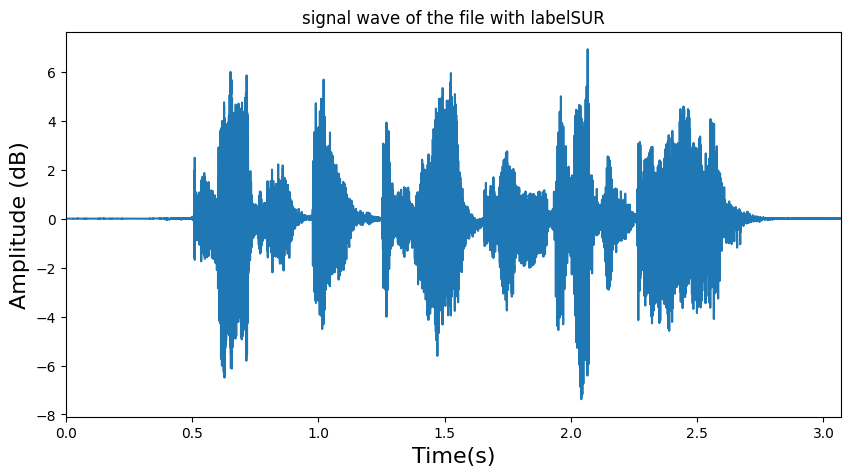

Audio file 'SUR':


In [41]:
random_idx = np.random.randint(len(labels))
random_label = labels[random_idx]
random_signal = signal[random_idx]

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(random_signal))/float(sample_rate), random_signal)
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time(s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title(f'signal wave of the file with label{random_label}')
plt.show()

print(f"Audio file '{random_label}':")
Audio(random_signal, rate= sample_rate)

In [29]:
nb_augmented = 2

def noisy_signal(signal, snr_low = 15, snr_high = 30, nb_augmented=2):
    signal_len= len(signal)
    noise=np.random.normal(size=(nb_augmented, signal_len))

    s_power = np.sum((signal/(2.0 ** 15)) ** 2)/ signal_len # why we should use 2.0 instead of 2
    n_power = np.sum((noise/ (2.0 ** 15)) ** 2, axis =1) / signal_len
    snr = np.random.randint(snr_low, snr_high)

    K = np.sqrt((s_power / n_power) * 10 ** (- snr / 10))
    K = np.ones((signal_len, nb_augmented)) * K  #re-traverse through all over this function so that you understand even more.

    return signal + K.T * noise

augmented_signal = list(map(noisy_signal, signal))


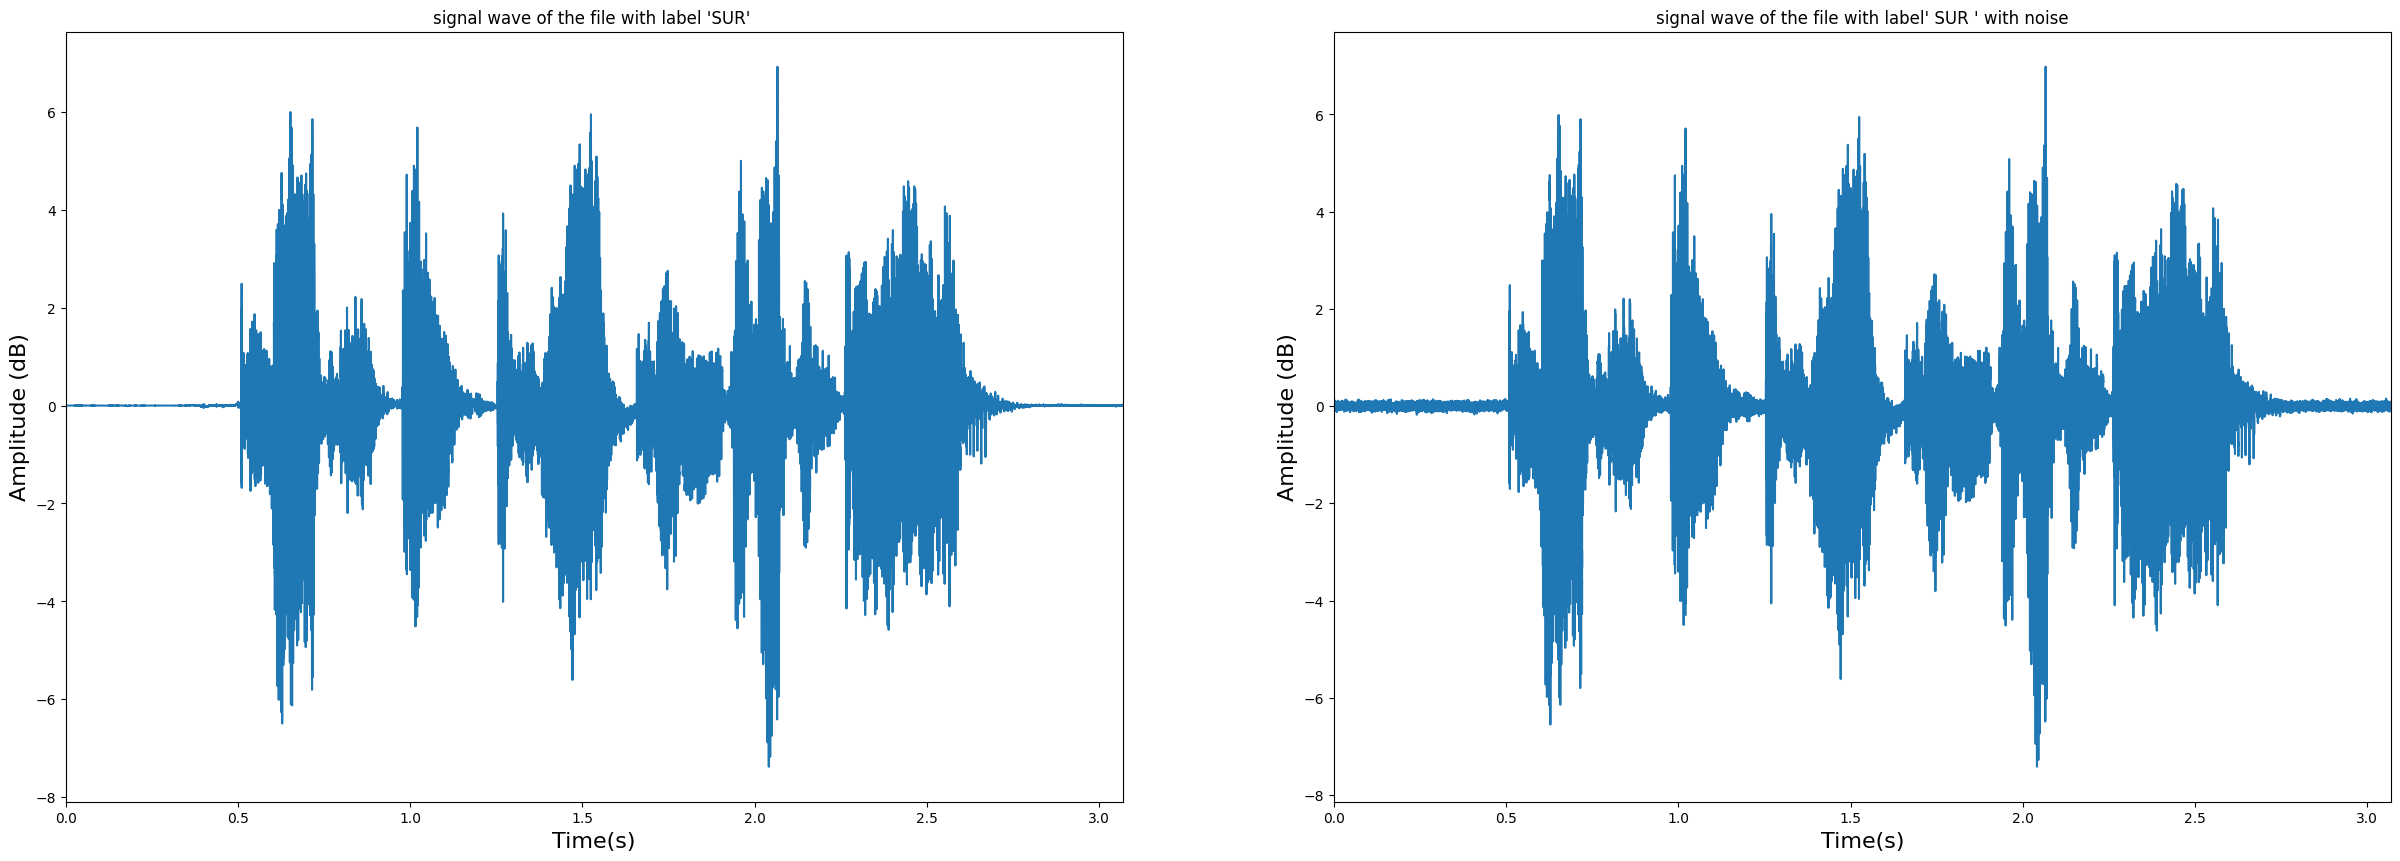

Audio file 'SUR':


Audio file 'SUR' with noise:


In [59]:
plt.figure(figsize=(30, 10))
plt.subplot(1,2,1)
plt.plot(np.arange(len(random_signal))/float(sample_rate), random_signal)
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time(s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title(f"signal wave of the file with label '{random_label}' ")

plt.subplot(1,2,2)  # learn more about sub plots

plt.plot(np.arange(len(random_signal))/float(sample_rate), augmented_signal[random_idx][0])
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time(s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title(f"signal wave of the file with label' {random_label} ' with noise")
plt.show()

print(f"Audio file '{random_label}':")
IPython.display.display(Audio(random_signal, rate= sample_rate))

print(f"Audio file '{random_label}' with noise:")
IPython.display.display(Audio(augmented_signal[random_idx][0], rate= sample_rate))

In [62]:
def mel_spectrogram(y, sr = 16000, n_fft=512, win_length = 256,
                    hop_length=128, window='hamming', n_mels=128, fmax=4000):

    mel_feat = np.abs(librosa.stft(y, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)) ** 2  #mainly about stft fouriou transform what is it.
    mel_feat =librosa.feature.melspectrogram(S= mel_feat, sr=sr, n_mels = n_mels, fmax=fmax)
    mel_feat = librosa.power_to_db(mel_feat, ref= np.max)

    return mel_feat

augumented_signal = list(map(noisy_signal, signal))# why this line is again added.

mel_spect = np.asarray(list(map(mel_spectrogram, signal)))
noisy_mel_spect = [np.asarray(list(map(mel_spectrogram, augmented_signal[i]))) for i in range(len(augmented_signal))]

In [78]:
org_mel_spec_train, org_mel_spec_test, noisy_mel_spec_train, noisy_spec_test, label_train, label_test = train_test_split(mel_spect, noisy_mel_spect, labels, test_size=0.2)

aug_label_train = np.asarray(list(itertools.chain.from_iterable([[label] * nb_augmented for label in label_train])))# what is this line
noisy_mel_spec_train = np.asarray(list(itertools.chain.from_iterable(noisy_mel_spec_train)))
X_train = np.concatenate((org_mel_spec_train, noisy_mel_spec_train))
y_train = np.concatenate((label_train, aug_label_train))

X_test = org_mel_spec_test
y_test = label_test


#del org_mel_spec_train, org_mel_spec_test, noisy_mel_spec_train, noisy_spec_test, label_train, label_test
#del mel_spect, noisy_mel_spect, labels


In [87]:
# this is for lstm need to understand carefully.
window_size = 128
gap = 64

def frame(x, step_size, window):
    n_frames = 1+ int((x.shape[2]- window) / step_size)
    frames = np.zeros((x.shape[0], n_frames, x.shape[1], window)).astype(np.float32)
    for t in range(n_frames):
        frames[:, t, :, :] = np.copy(x[:, :, (t * step_size): (t*step_size + window)]).astype(np.float32) # why there are four points for slicing. yeah in the abouve line we just created as 4darray
    return frames

X_train = frame(X_train, gap, window_size)
X_test = frame(X_test, gap, window_size) # need to know why this frame function is needed for lstm.


In [89]:
# we can you joblib right. see the diff of both pickle and joblib
pickle.dump(X_train.astype(np.float16), open('/home/badri/mine/ser/datasets/MFCC_Features/train_and_test_pickle/[revdess][mel_spect][x_train].p', 'wb')) #here float16 from float32. may be because of this pickle might be used. see if this possible in joblib
#why .p

In [90]:
pickle.dump(y_train, open('/home/badri/mine/ser/datasets/MFCC_Features/train_and_test_pickle/[revdess][mel_spect][y_train].p', 'wb'))
#why no astype for this

In [91]:
pickle.dump(X_test.astype(np.float16), open('/home/badri/mine/ser/datasets/MFCC_Features/train_and_test_pickle/[revdess][mel_spect][x_test].p', 'wb'))

In [1]:
import os
from glob import glob
import pickle
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import LSTM, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as k
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder


2025-01-30 15:11:05.068956: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 15:11:05.185233: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 15:11:05.286556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738230065.387186    5284 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738230065.417972    5284 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-30 15:11:05.643229: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
X_train = pickle.load(open('/home/badri/mine/ser/datasets/MFCC_Features/train_and_test_pickle/[revdess][mel_spect][x_train].p', 'rb'))
X_test = pickle.load(open('/home/badri/mine/ser/datasets/MFCC_Features/train_and_test_pickle/[revdess][mel_spect][x_test].p', 'rb'))
y_train = pickle.load(open('/home/badri/mine/ser/datasets/MFCC_Features/train_and_test_pickle/[revdess][mel_spect][y_train].p', 'rb'))
y_test =  pickle.load(open('/home/badri/mine/ser/datasets/MFCC_Features/train_and_test_pickle/[revdess][mel_spect][y_test].p', 'rb'))

In [3]:
#is to_categorical only converts to one hot encoding
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(np.ravel(y_train)))
y_test = to_categorical(lb.transform(np.ravel(y_test)))

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3], 1)


In [4]:
input_y = Input(shape=X_train.shape[1:], name='Input')

y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding= 'same'),  name='conv_1')(input_y) # why Iam again calling the the obkect with  input_y
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1')(y)
y = TimeDistributed(Activation('elu'), name="Activ_1")(y)
y= TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding= 'same'), name='MaxPool_1')(y)



2025-01-30 15:11:17.236839: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
y = TimeDistributed(Dropout(0.2), name='Drop_1')(y)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding= 'same'),  name='conv_2')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2')(y)
y = TimeDistributed(Activation('elu'), name="Activ_2")(y)
y= TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding= 'same'), name='MaxPool_2')(y)
y = TimeDistributed(Dropout(0.1), name= 'Drop_2')(y)

y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding= 'same'), name='conv_3')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3')(y)
y = TimeDistributed(Activation('elu'), name="Activ_3")(y)
y= TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding= 'same'), name='MaxPool_3')(y)
y = TimeDistributed(Dropout(0.1), name= 'Drop_3')(y)

y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding= 'same'), name='conv_4')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4')(y)
y = TimeDistributed(Activation('elu'), name="Activ_4")(y)
y= TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding= 'same'), name='MaxPool_4')(y)
y = TimeDistributed(Dropout(0.2), name= 'Drop_4')(y)


In [6]:
y = TimeDistributed(Flatten(), name= 'Flat')(y)

y = LSTM(256, return_sequences = False, dropout=0.2, name='LSTM_1')(y)
y = Dense(y_train.shape[1], activation='softmax', name='FC')(y)

In [7]:
model = Model(inputs=input_y, outputs=y)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 5, 128, 128, 1) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (TimeDistributed)        │ (None, 5, 128, 128,    │           640 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_1 (TimeDistributed)   │ (None, 5, 128, 128,    │           256 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Activ_1 (TimeDistributed)       │ (None, 5, 128, 128,    │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_1 (TimeDistributed)     │ (None, 5, 64, 64, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_1 (TimeDistributed)        │ (None, 5, 64, 64, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (TimeDistributed)        │ (None, 5, 64, 64, 64)  │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_2 (TimeDistributed)   │ (None, 5, 64, 64, 64)  │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Activ_2 (TimeDistributed)       │ (None, 5, 64, 64, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_2 (TimeDistributed)     │ (None, 5, 16, 16, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_2 (TimeDistributed)        │ (None, 5, 16, 16, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (TimeDistributed)        │ (None, 5, 16, 16, 128) │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_3 (TimeDistributed)   │ (None, 5, 16, 16, 128) │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Activ_3 (TimeDistributed)       │ (None, 5, 16, 16, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_3 (TimeDistributed)     │ (None, 5, 4, 4, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_3 (TimeDistributed)        │ (None, 5, 4, 4, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (TimeDistributed)        │ (None, 5, 4, 4, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_4 (TimeDistributed)   │ (None, 5, 4, 4, 128)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Activ_4 (TimeDistributed)       │ (None, 5, 4, 4, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_4 (TimeDistributed)     │ (None, 5, 1, 1, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_4 (TimeDistributed)        │ (None, 5, 1, 1, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flat (TimeDistributed)          │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 656,583 (2.50 MB)

 Trainable params: 655,815 (2.50 MB)

 Non-trainable params: 768 (3.00 KB)

In [8]:
%%time

from tensorflow.keras.optimizers import schedules

lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps = 100000,
    decay_rate=0.99,
    staircase=True
)
model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, mode='max')
history = model.fit(X_train, y_train, 
                    batch_size=32,
                   epochs=100,
                   validation_data=(X_test, y_test),
                   callbacks=[early_stopping])

Epoch 1/100


2025-01-30 15:11:29.893505: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1056768000 exceeds 10% of free system memory.
2025-01-30 15:11:41.453374: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 671088640 exceeds 10% of free system memory.
2025-01-30 15:11:42.009618: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 671088640 exceeds 10% of free system memory.
2025-01-30 15:11:42.289402: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 671088640 exceeds 10% of free system memory.
2025-01-30 15:11:46.016053: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 671088640 exceeds 10% of free system memory.


  1/101 ━━━━━━━━━━━━━━━━━━━━ 31:11 19s/step - accuracy: 0.0000e+00 - loss: 2.2246

KeyboardInterrupt: 